<a href="https://colab.research.google.com/github/tskmr/SystemReliability/blob/main/Lec11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
library(tidyverse)
if(!require(geomtextpath)) install.packages("geomtextpath")
library(geomtextpath)

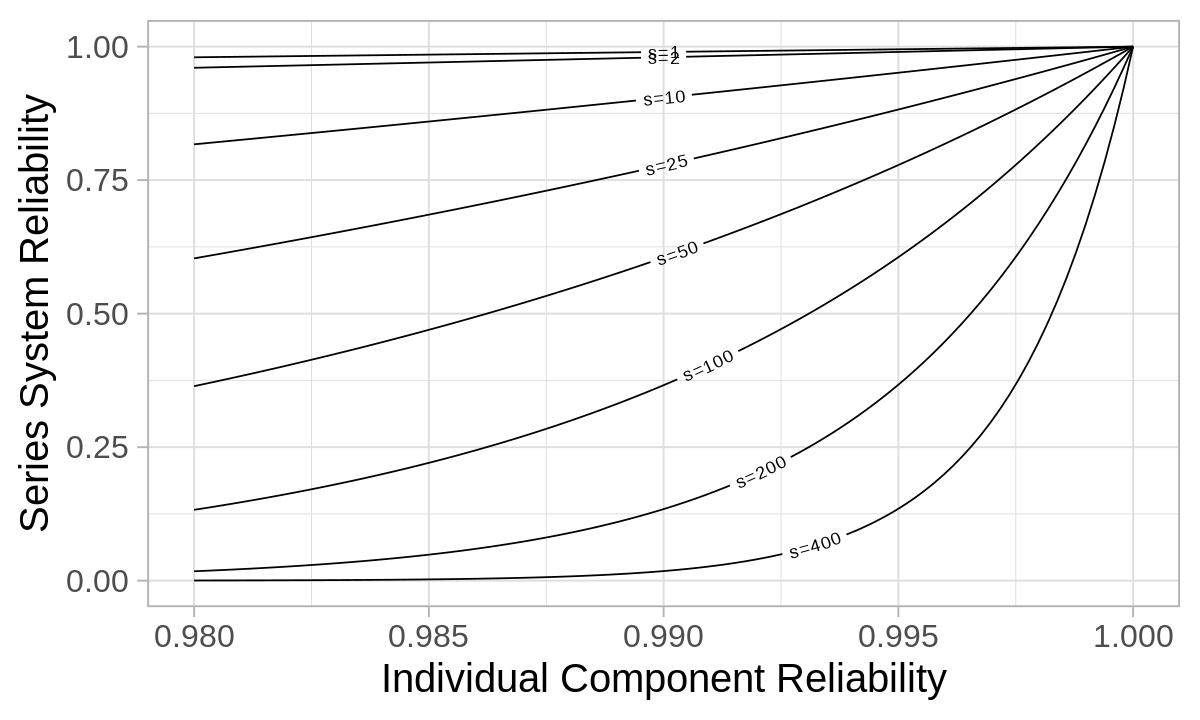

In [10]:
Rs = function(s, R){
   R^s
}
s = c(1, 2, 10, 25, 50, 100, 200, 400)
R = seq(0.98, 1, len=100)
d = expand.grid(s=s, R=R)

options(repr.plot.width = 10, repr.plot.height = 6)
d %>% mutate(pr = Rs(s, R)) %>%
   ggplot(aes(R, pr, label=paste0("s=", s), group=s)) +
   geomtextpath::geom_textline()+
   theme_light(24)+
   ylab("Series System Reliability") +
   xlab("Individual Component Reliability")


Warning message:
“Removed 71 rows containing missing values (`geom_textline()`).”


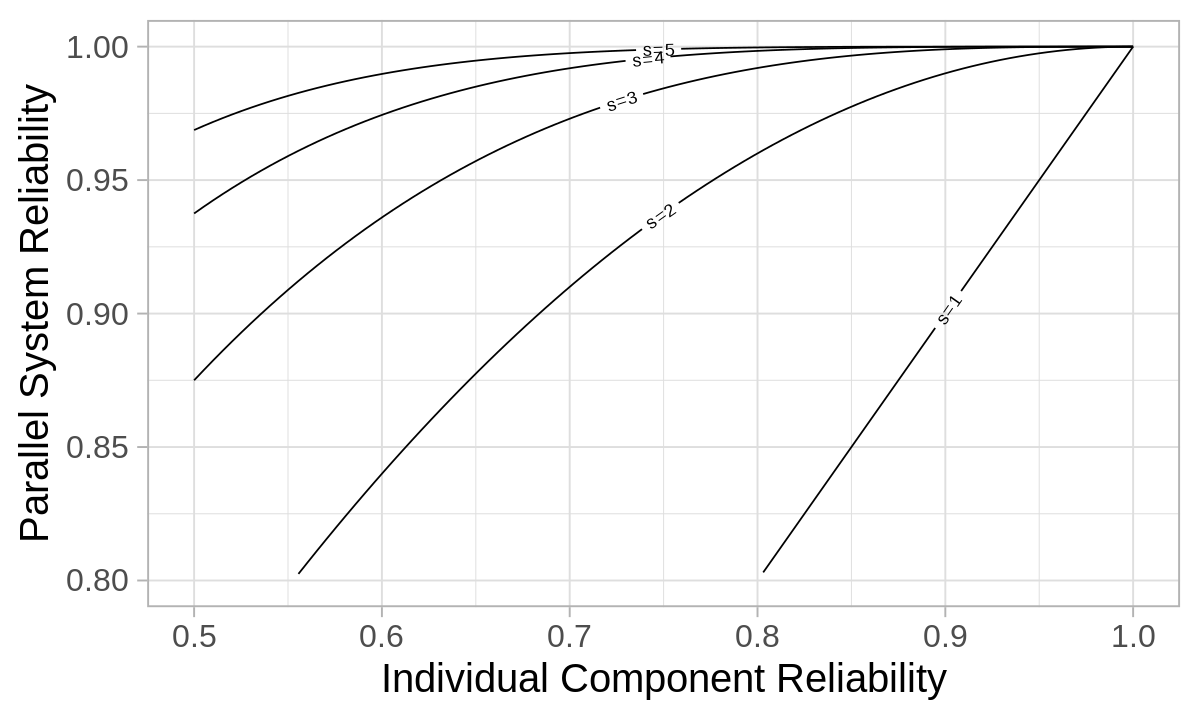

In [11]:
Rs = function(s, R){
   1-(1-R)^s
}
s = c(1, 2, 3, 4, 5)
R = seq(0.5, 1, len=100)
d = expand.grid(s=s, R=R)

options(repr.plot.width = 10, repr.plot.height = 6)
d %>% mutate(pr = Rs(s, R)) %>%
   ggplot(aes(R, pr, label=paste0("s=", s), group=s)) +
   geomtextpath::geom_textline()+
   theme_light(24)+
   ylab("Parallel System Reliability") +
   xlab("Individual Component Reliability")+
   ylim(c(0.8, 1))


## Device G

In [12]:
library(tidyverse)
if(!require(geomtextpath)) install.packages("geomtextpath")

In [13]:
psev = function(z){ 1-exp(-exp(z)) }
dsev = function(z){ exp(z-exp(z)) }
qsev = function(p){ log(-log(1-p)) }

pdf = function(t, mu, sigma){
  1/(sigma*t) * dsev( (log(t)-mu)/sigma )
}
cdf = function(t, mu, sigma){
  psev( (log(t)-mu)/sigma )
}


In [14]:
loglikelihood = function(data){
  function(par){
    sum(log(li(par, data)))
  }
}
li = function(par, data){
  mu = par[1]
  sigma = par[2]
  t = data[,1]
  delta = data[,2]
  pdf(t, mu, sigma)^delta * (1-cdf(t, mu, sigma))^(1-delta)
}


In [15]:
d = read_csv("DeviceG.csv")
colnames(d) = c("t", "mode")

results = list()


Rows: 30 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Failure Mode
dbl (1): Thousands of Cycles

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Serge

In [16]:
data0 = d %>% mutate(delta = if_else(mode=="Surge", 1, 0))
data = data0 %>% select(t, delta)
loglikelihood(data)(c(6, 1))

mlem = optim(c(6, 1), loglikelihood(data), control=list(fnscale=-1), hessian = TRUE)
mle = mlem$par
Sigma.mle = solve(-mlem$hessian)

hat.mu = mle[1]
se.hat.mu = sqrt(diag(Sigma.mle)[1])
ci95l.hat.mu = hat.mu - se.hat.mu * qnorm(0.975)
ci95u.hat.mu = hat.mu + se.hat.mu * qnorm(0.975)
c(ci95l.hat.mu, ci95u.hat.mu)

hat.sigma = mle[2]
se.hat.sigma = sqrt(diag(Sigma.mle)[2])
w = exp(qnorm(0.975) * se.hat.sigma/ hat.sigma)
ci95l.hat.sigma = hat.sigma / w
ci95u.hat.sigma = hat.sigma * w
c(ci95l.hat.sigma, ci95u.hat.sigma)

results$S = data.frame(mode = "S",
                 hat.mu, se.hat.mu, ci95l.hat.mu, ci95u.hat.mu,
                 hat.sigma, se.hat.sigma, ci95l.hat.sigma, ci95u.hat.sigma
                 )
results$S.data = data0


[1] -103.1647

[1] 5.271233 6.945218

[1] 0.9399134 2.3622116

#### Wearout

In [17]:
data0 = d %>% mutate(delta = if_else(mode=="Wearout", 1, 0))
data = data0 %>% select(t, delta)
loglikelihood(data)(c(6, 1))

mlem = optim(c(6, 1), loglikelihood(data), control=list(fnscale=-1), hessian = TRUE)
mle = mlem$par
Sigma.mle = solve(-mlem$hessian)

hat.mu = mle[1]
se.hat.mu = sqrt(diag(Sigma.mle)[1])
ci95l.hat.mu = hat.mu - se.hat.mu * qnorm(0.975)
ci95u.hat.mu = hat.mu + se.hat.mu * qnorm(0.975)
c(ci95l.hat.mu, ci95u.hat.mu)

hat.sigma = mle[2]
se.hat.sigma = sqrt(diag(Sigma.mle)[2])
w = exp(qnorm(0.975) * se.hat.sigma/ hat.sigma)
ci95l.hat.sigma = hat.sigma / w
ci95u.hat.sigma = hat.sigma * w
c(ci95l.hat.sigma, ci95u.hat.sigma)

results$W = data.frame(mode = "W",
                       hat.mu, se.hat.mu, ci95l.hat.mu, ci95u.hat.mu,
                       hat.sigma, se.hat.sigma, ci95l.hat.sigma, ci95u.hat.sigma
)
results$W.data = data0



[1] -55.16465

[1] 5.622002 6.038179

[1] 0.1197000 0.4439612

#### S & W


In [18]:

data0 = d %>% mutate(delta = if_else(mode%in% c("Surge", "Wearout"), 1, 0))
data = data0 %>% select(t, delta)
loglikelihood(data)(c(6, 1))

mlem = optim(c(6, 1), loglikelihood(data), control=list(fnscale=-1), hessian = TRUE)
mle = mlem$par
Sigma.mle = solve(-mlem$hessian)

hat.mu = mle[1]
se.hat.mu = sqrt(diag(Sigma.mle)[1])
ci95l.hat.mu = hat.mu - se.hat.mu * qnorm(0.975)
ci95u.hat.mu = hat.mu + se.hat.mu * qnorm(0.975)
c(ci95l.hat.mu, ci95u.hat.mu)

hat.sigma = mle[2]
se.hat.sigma = sqrt(diag(Sigma.mle)[2])
w = exp(qnorm(0.975) * se.hat.sigma/ hat.sigma)
ci95l.hat.sigma = hat.sigma / w
ci95u.hat.sigma = hat.sigma * w
c(ci95l.hat.sigma, ci95u.hat.sigma)

results$SW = data.frame(mode = "SW",
                       hat.mu, se.hat.mu, ci95l.hat.mu, ci95u.hat.mu,
                       hat.sigma, se.hat.sigma, ci95l.hat.sigma, ci95u.hat.sigma
)
results$SW.data = data0


[1] -145.1647

[1] 5.039567 5.943576

[1] 0.7427821 1.5685516

In [19]:
results


$S
  mode   hat.mu se.hat.mu ci95l.hat.mu ci95u.hat.mu hat.sigma se.hat.sigma
1    S 6.108225  0.427045     5.271233     6.945218  1.490059    0.3503093
  ci95l.hat.sigma ci95u.hat.sigma
1       0.9399134        2.362212

$S.data
# A tibble: 30 × 3
       t mode      delta
   <dbl> <chr>     <dbl>
 1   275 Wearout       0
 2    13 Surge         1
 3   147 Wearout       0
 4    23 Surge         1
 5   181 Wearout       0
 6    30 Surge         1
 7    65 Surge         1
 8    10 Surge         1
 9   300 Suspended     0
10   173 Surge         1
# ℹ 20 more rows

$W
  mode  hat.mu se.hat.mu ci95l.hat.mu ci95u.hat.mu hat.sigma se.hat.sigma
1    W 5.83009 0.1061696     5.622002     6.038179 0.2305259    0.0770834
  ci95l.hat.sigma ci95u.hat.sigma
1          0.1197       0.4439612

$W.data
# A tibble: 30 × 3
       t mode      delta
   <dbl> <chr>     <dbl>
 1   275 Wearout       1
 2    13 Surge         0
 3   147 Wearout       1
 4    23 Surge         0
 5   181 Wearout       1
 6    30 Surge         0
 7    65 Surge         0
 8    10 Surge         0
 9   300 Suspended     0
10   173 Surge         0
# ℹ 20 more rows

$SW
  mode   hat.mu se.hat.mu ci95l.hat.mu ci95u.hat.mu hat.sigma se.hat.sigma
1   SW 5.491572 0.2306186     5.039567     5.943576  1.079394    0.2058336
  ci95l.hat.sigma ci95u.hat.sigma
1       0.7427821        1.568552

$SW.data
# A tibble: 30 × 3
       t mode      delta
   <dbl> <chr>     <dbl>
 1   275 Wearout       1
 2    13 Surge         1
 3   147 Wearout       1
 4    23 Surge         1
 5   181 Wearout       1
 6    30 Surge         1
 7    65 Surge         1
 8    10 Surge         1
 9   300 Suspended     0
10   173 Surge         1
# ℹ 20 more rows

#### SW 可視化

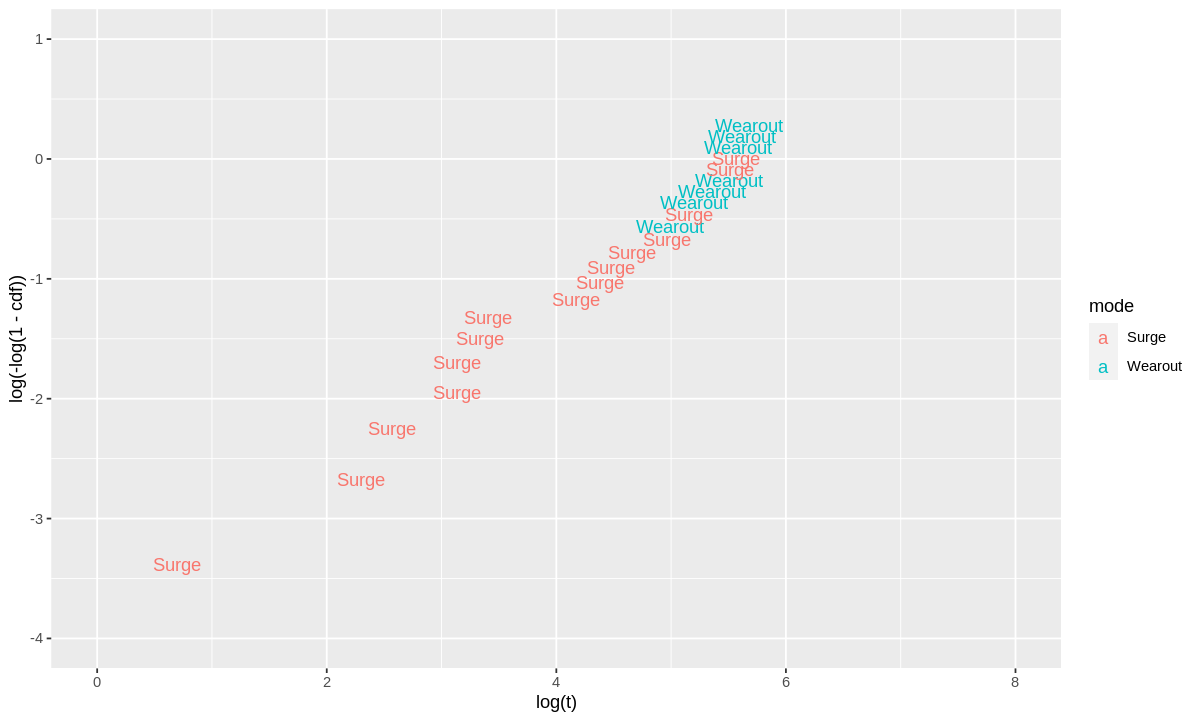

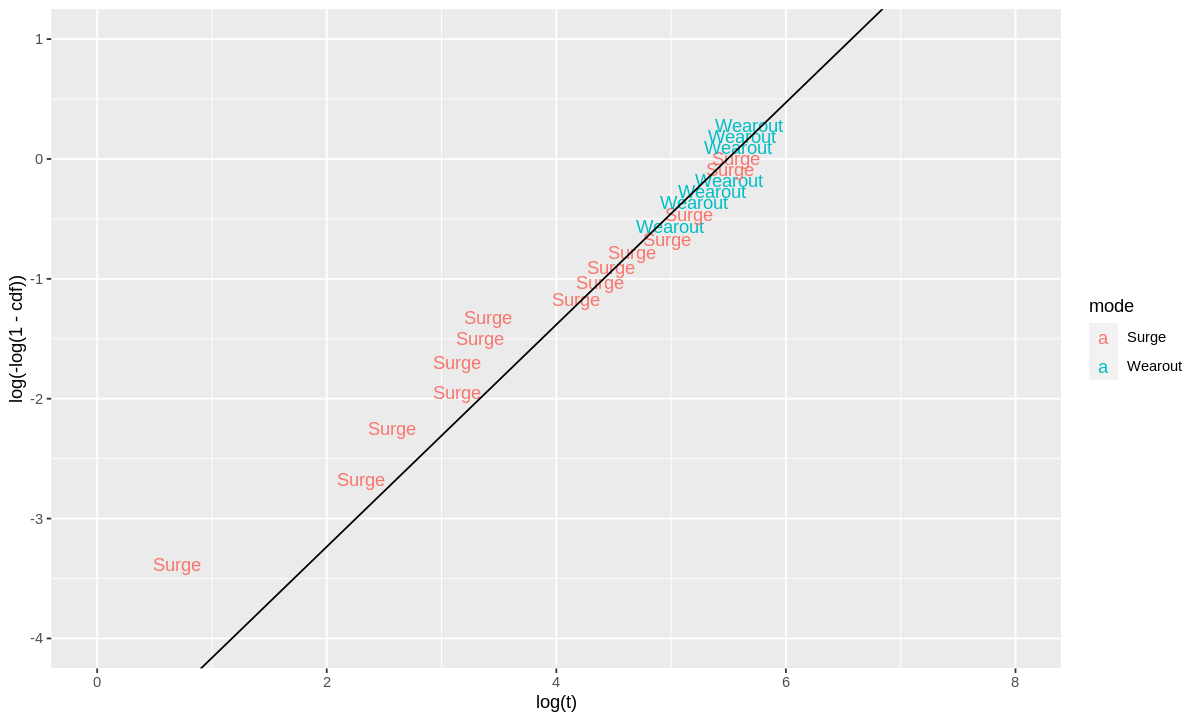

In [20]:

data= results$SW.data
km = data %>% arrange(t) %>%
  mutate(nj = rev(seq_along(t))) %>%
  filter(delta == 1) %>%
  mutate(p = delta/nj) %>%
  mutate(cdf = 1-cumprod(1-p))
p1 = km %>% ggplot() + geom_text(aes(log(t), log(-log(1-cdf)), label=mode, col=mode))+ xlim(c(0, 8)) + ylim(c(-4, 1))
p1

dd = results$SW
p1 = p1 + geom_abline(slope = 1/dd$hat.sigma, intercept = -dd$hat.mu/dd$hat.sigma)
p1


#### SとWの可視化

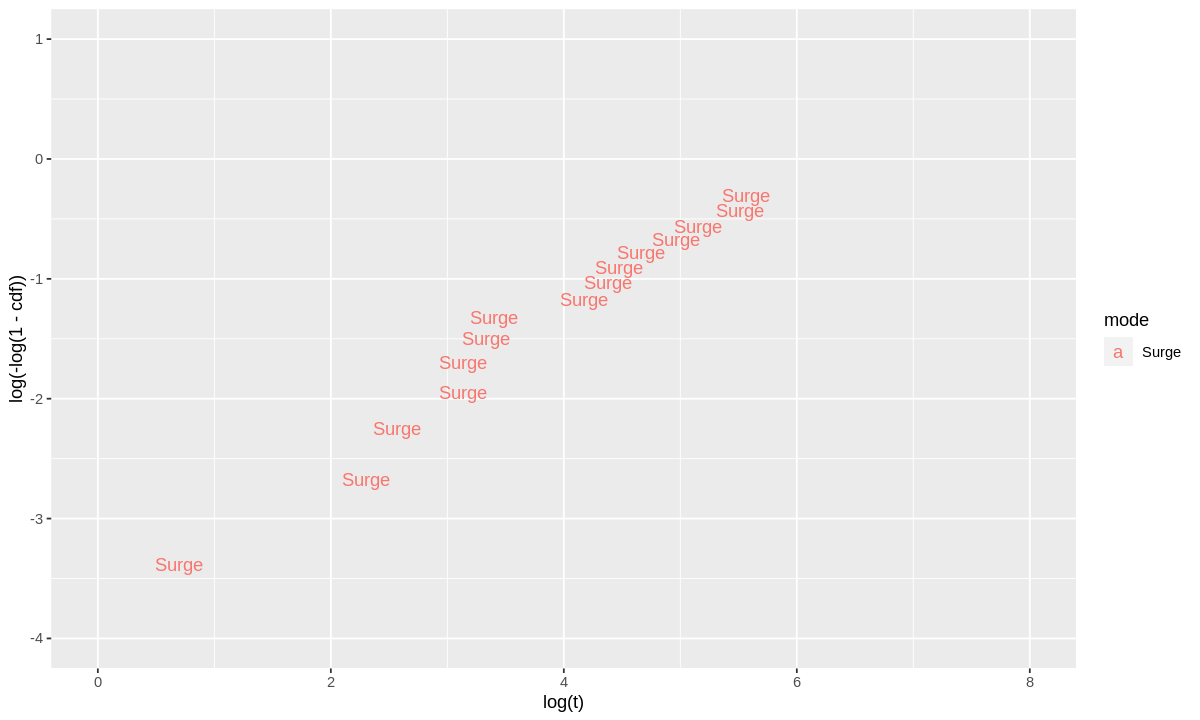

In [21]:
data= results$S.data
kmS = data %>% arrange(t) %>%
  mutate(nj = rev(seq_along(t))) %>%
  filter(delta == 1) %>%
  mutate(p = delta/nj) %>%
  mutate(cdf = 1-cumprod(1-p))
p1 = kmS %>% ggplot() + geom_text(aes(log(t), log(-log(1-cdf)), label=mode, col=mode)) + xlim(c(0, 8)) + ylim(c(-4, 1))
p1


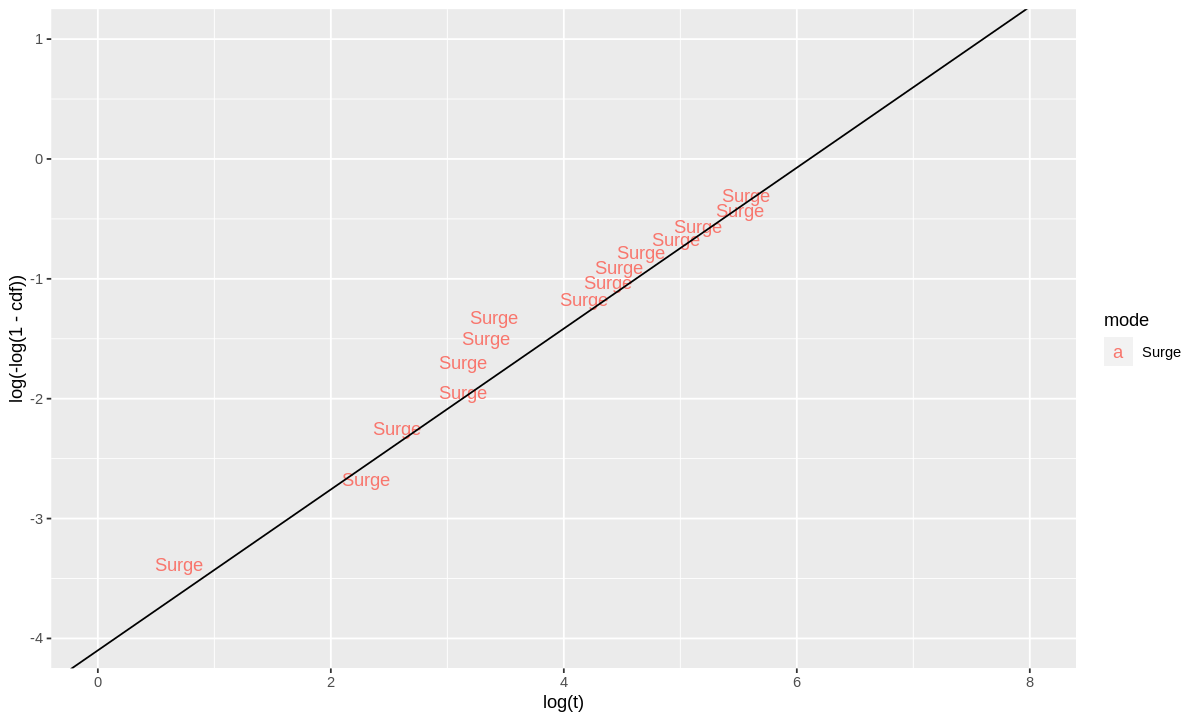

In [22]:
dd = results$S
p1 = p1 + geom_abline(slope = 1/dd$hat.sigma, intercept = -dd$hat.mu/dd$hat.sigma)
p1


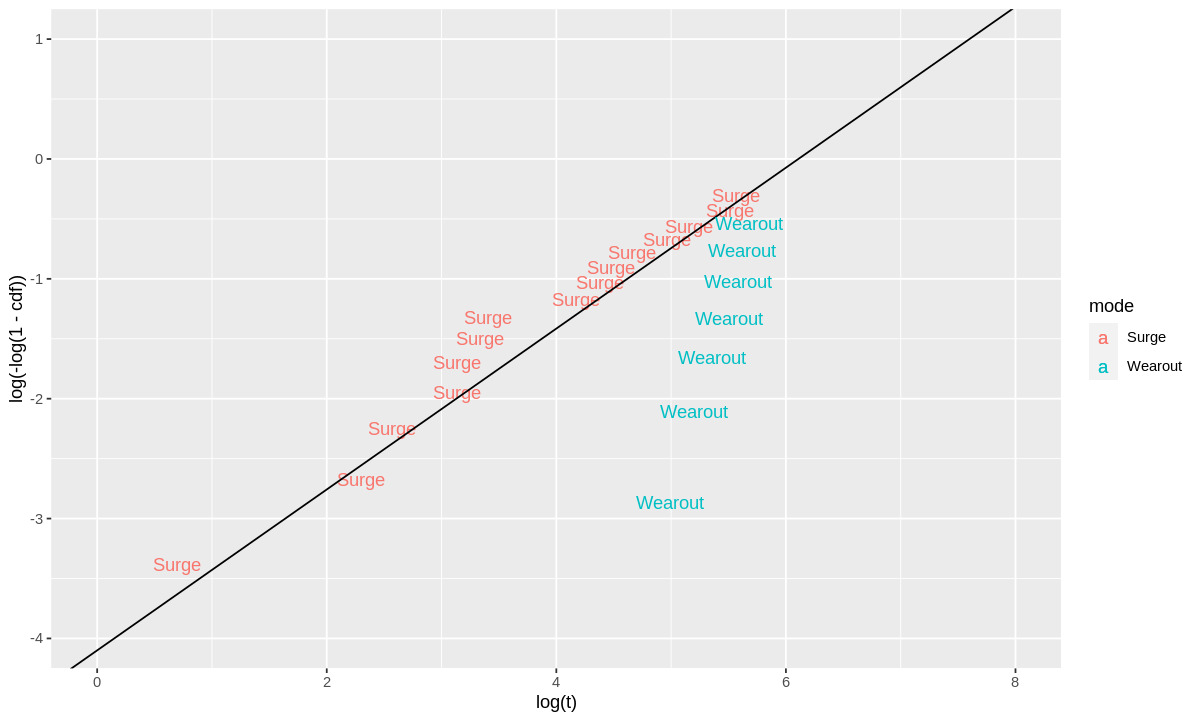

In [23]:
data= results$W.data
kmW = data %>% arrange(t) %>%
  mutate(nj = rev(seq_along(t))) %>%
  filter(delta == 1) %>%
  mutate(p = delta/nj) %>%
  mutate(cdf = 1-cumprod(1-p))
p2 = p1 + geom_text(data=kmW, aes(log(t), log(-log(1-cdf)), label=mode, col=mode))
p2


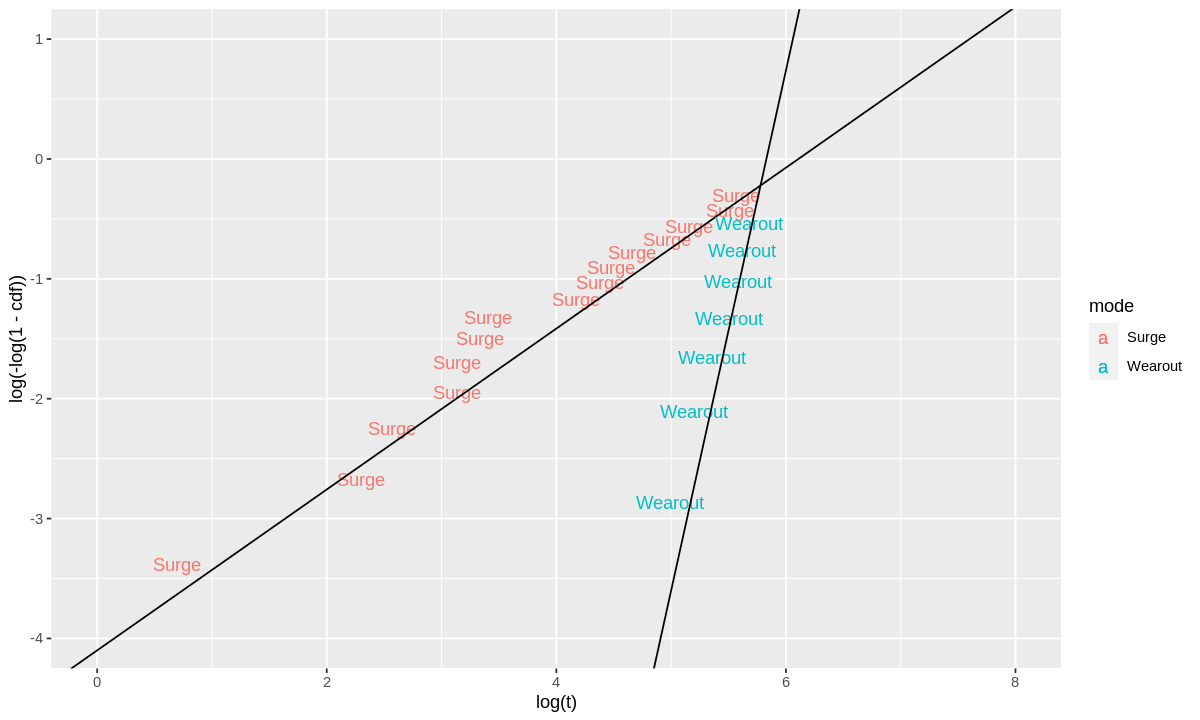

In [24]:
dd = results$W
p2 = p2 + geom_abline(slope = 1/dd$hat.sigma, intercept = -dd$hat.mu/dd$hat.sigma)
p2


#### 直列システムの可視化

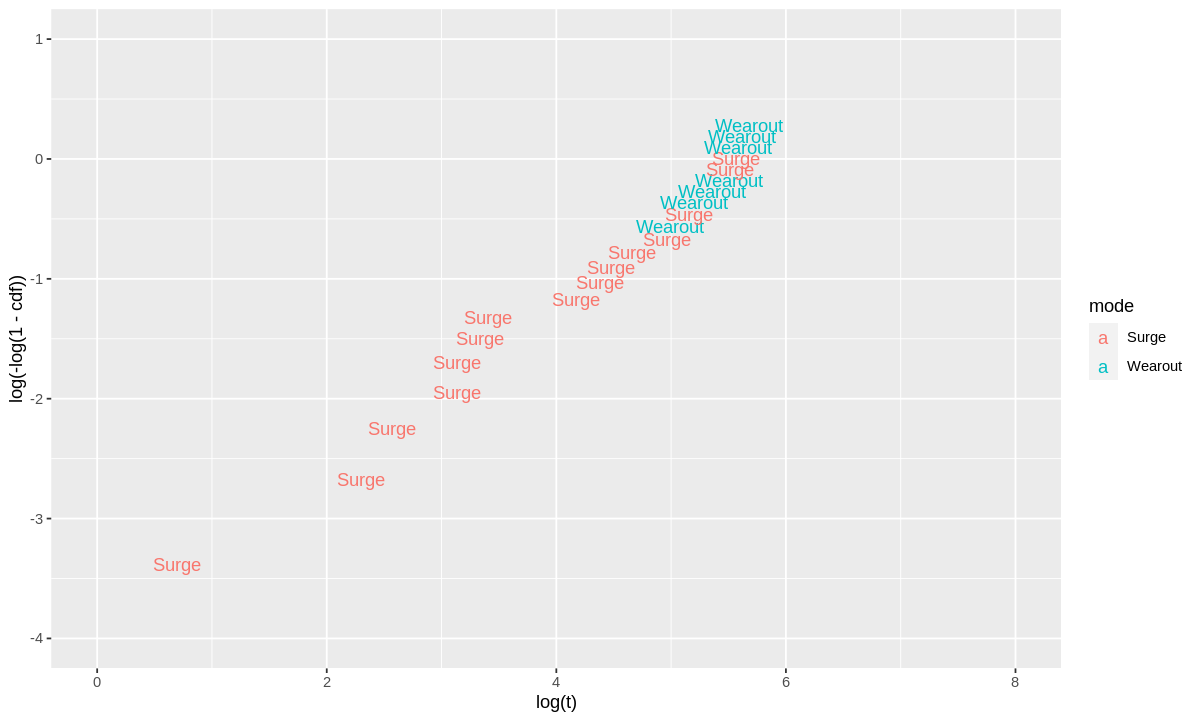

In [31]:
data= results$SW.data
km = data %>% arrange(t) %>%
  mutate(nj = rev(seq_along(t))) %>%
  filter(delta == 1) %>%
  mutate(p = delta/nj) %>%
  mutate(cdf = 1-cumprod(1-p))
p1 = km %>% ggplot() + geom_text(aes(log(t), log(-log(1-cdf)), label=mode, col=mode)) + xlim(c(0, 8)) + ylim(c(-4, 1))
p1


Warning message:
“Removed 2 rows containing missing values (`geom_line()`).”


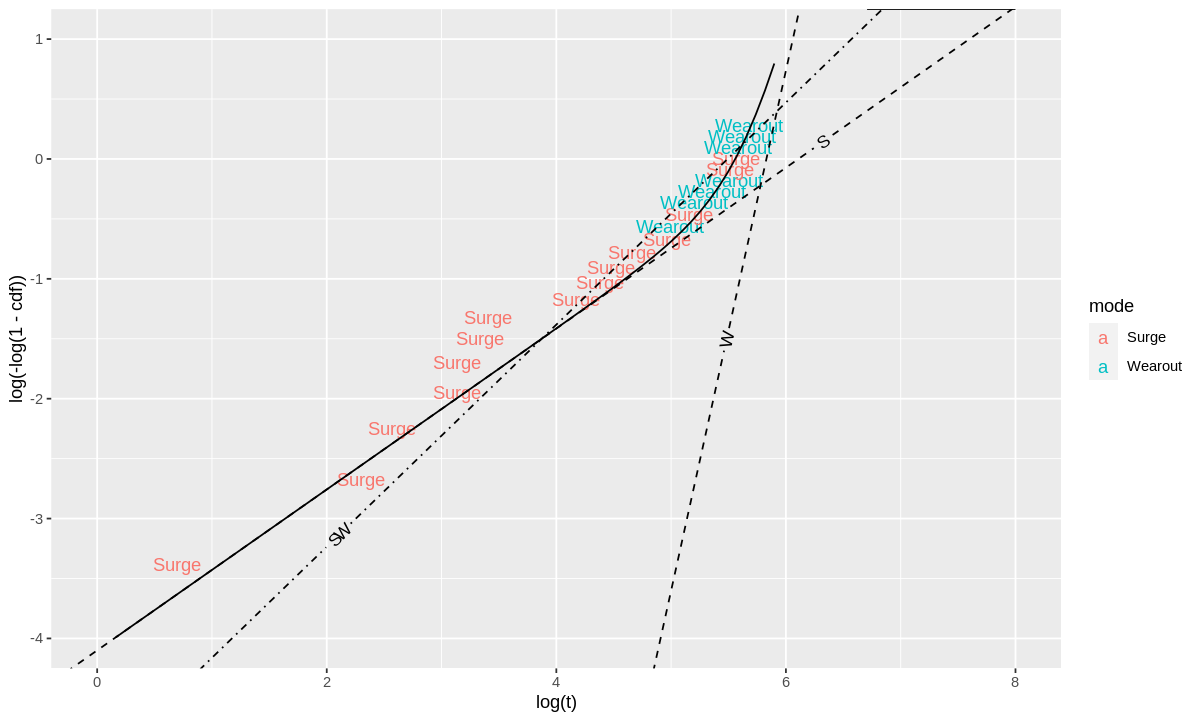

In [32]:

ddS = results$S
ddW = results$W
log.t = seq(0, 8, len=100)
FS = psev( (log.t - ddS$hat.mu)/ ddS$hat.sigma)
FW = psev( (log.t - ddW$hat.mu)/ ddW$hat.sigma)
FT = 1- (1-FS)*(1-FW)
ddT = data.frame(log.t, FT)
p1 = p1 + geom_line(data=ddT, aes(x=log.t, y=log(-log(1-FT))))
p1 = p1 +
  geomtextpath::geom_textabline(slope = 1/ddS$hat.sigma, intercept = -ddS$hat.mu/ddS$hat.sigma, linetype=2, label="S", hjust = .8)+
  geomtextpath::geom_textabline(slope = 1/ddW$hat.sigma, intercept = -ddW$hat.mu/ddW$hat.sigma, linetype=2, label="W")

ddSW = results$SW
p1 = p1 + geomtextpath::geom_textabline(slope = 1/ddSW$hat.sigma, intercept = -ddSW$hat.mu/ddSW$hat.sigma, linetype=4, label="SW", hjust = .2)
p1

In [72]:
?scale_x_continuous

[1] 0.001 0.010 0.100 0.200 0.300 0.500 0.700 0.900 0.990 0.999

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


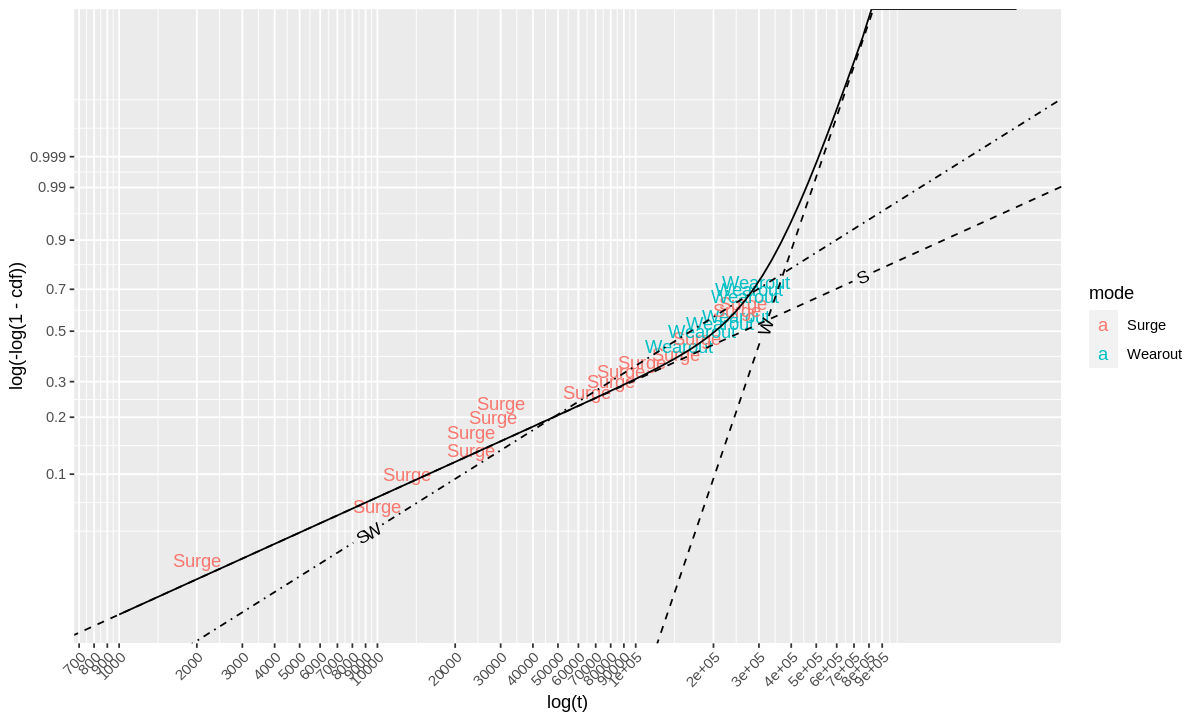

In [82]:
xticks = c(c(1:9)/10, c(1:9)/1, c(1:9)*10, c(1:9)*100)
yticks = c(0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 0.99, 0.999)
yticks
p1 + scale_x_continuous(
  breaks = log(xticks),
  labels = xticks*1000
) +
  scale_y_continuous(
    breaks = log(-log(1-yticks)),
    labels = yticks,
  )+
    theme(axis.text.x = element_text(angle=45, hjust=1))